In [ ]:
from heston_model import HestonModel
from heston_calibration import calibrate, bs_implied_vol, get_vol_slice
from heston_pricer import Pricer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Update imports constantly
%load_ext autoreload
%autoreload 2

### ***1. Calibration***

In [52]:
# Heston model params
init_params = {'kappa': 2.0,'theta': 0.04,'xi': 0.3,'rho': -0.7,'v0': 0.04}
model = HestonModel(init_params)    

# Input data
file = r'Calibration_Template_2024-09-30.xlsx'
market_data = pd.read_excel(file, sheet_name='Market_Data')
surf = pd.read_excel(file, sheet_name='Vol_Matrix', index_col=0)

T = 1 # 1 year maturity for calibration

# Risk Free Rate 
rate_curve = market_data[['Year_Frac', 'Risk_Free_Rate']].drop_duplicates().sort_values('Year_Frac')
times, rates = rate_curve['Year_Frac'].values, rate_curve['Risk_Free_Rate'].values
r = np.interp(T, times, rates)

# Div Yield
div_curve = market_data[['Year_Frac', 'Div_Yield']].drop_duplicates().sort_values('Year_Frac')
times, divs = div_curve['Year_Frac'].values, div_curve['Div_Yield'].values
q = - np.interp(T, times, divs)

# Spot Price
S0 = market_data['S0'][0]

# Calibration
res = calibrate(model, surf, S0, r, T, q)

Calibration successful:
Iterations: 169
Total Error: 1.08046e-01.

Parameters:
kappa: 6.10671, theta: 0.12614, xi: 1.24120, rho: -0.36579, v0: 0.00250

Market vs Model prices differences (%):
Moneyness 40.00%: Model vs Market difference: -0.1274%
Moneyness 45.00%: Model vs Market difference: -0.1318%
Moneyness 50.00%: Model vs Market difference: -0.1409%
Moneyness 55.00%: Model vs Market difference: -0.1236%
Moneyness 60.00%: Model vs Market difference: -0.0811%
Moneyness 65.00%: Model vs Market difference: -0.0194%
Moneyness 70.00%: Model vs Market difference: 0.0471%
Moneyness 75.00%: Model vs Market difference: 0.1126%
Moneyness 80.00%: Model vs Market difference: 0.1581%
Moneyness 85.00%: Model vs Market difference: 0.1594%
Moneyness 90.00%: Model vs Market difference: 0.1225%
Moneyness 95.00%: Model vs Market difference: 0.0458%
Moneyness 100.00%: Model vs Market difference: -0.0517%
Moneyness 105.00%: Model vs Market difference: -0.1566%
Moneyness 110.00%: Model vs Market differe

### ***2. Smile Fit***

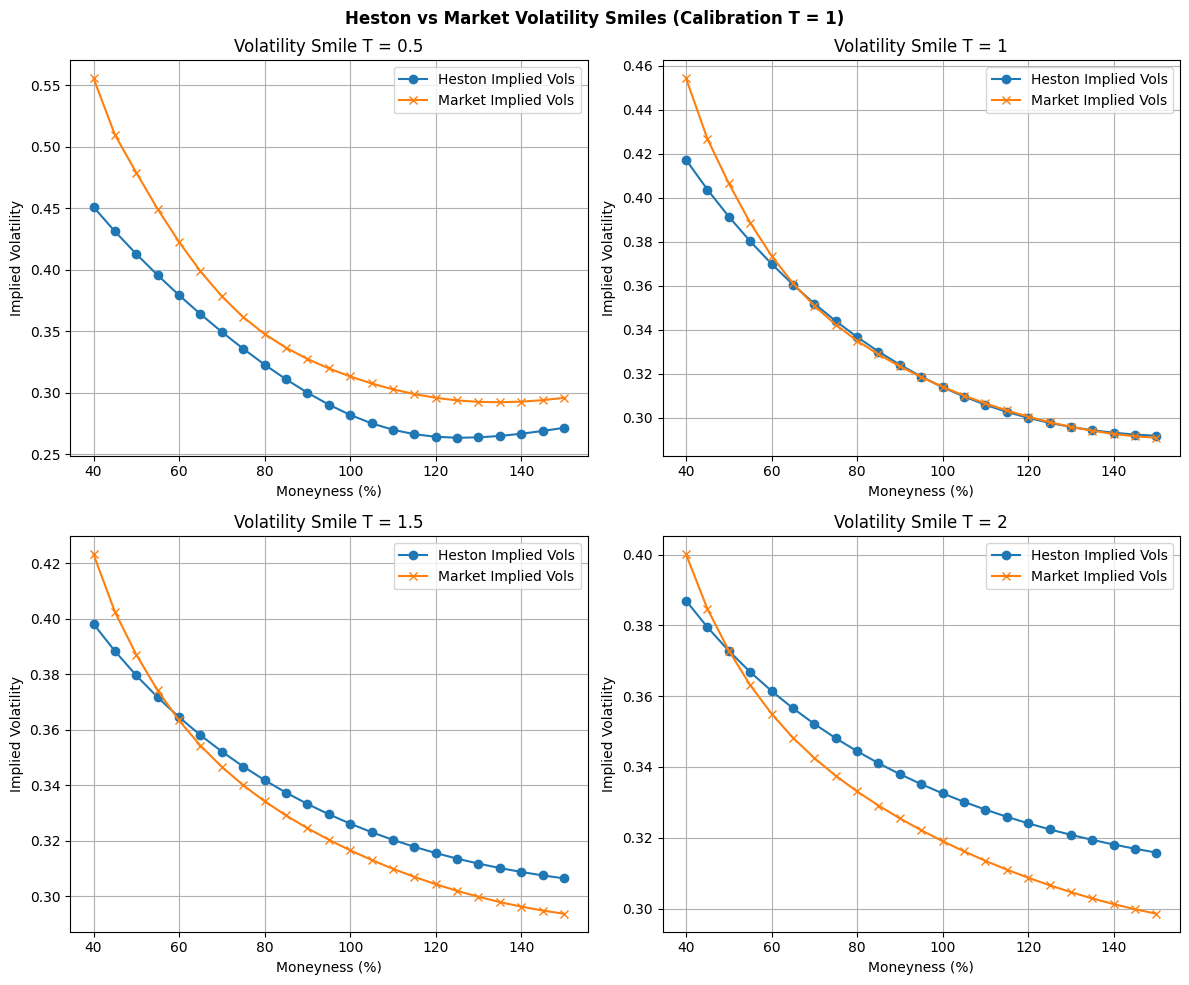

In [58]:
# Create subplots for different maturities
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
T_values = [0.5, 1, 1.5, 2]  

for i in range(len(T_values)):
    moneyness, market_vols = get_vol_slice(surf, T_values[i])
    K_vals = moneyness * S0 / 100
    heston_prices = model.heston_call(T_values[i], S0, r, q, K_vals)
    heston_vols = [bs_implied_vol(S0, K, T_values[i], r, q, C) for K, C in zip(K_vals, heston_prices)]
    
    # Plot on the corresponding subplot
    axes[i].plot(moneyness, heston_vols, 'o-', label='Heston Implied Vols')
    axes[i].plot(moneyness, market_vols, 'x-', label='Market Implied Vols')
    axes[i].set_xlabel('Moneyness (%)')
    axes[i].set_ylabel('Implied Volatility')
    axes[i].set_title(f'Volatility Smile T = {T_values[i]}')
    axes[i].legend()
    axes[i].grid()

# Title
fig.suptitle(f'Heston vs Market Volatility Smiles (Calibration T = {T})', fontweight='bold')
plt.tight_layout()
plt.show()

### ***3. Volatility Process***

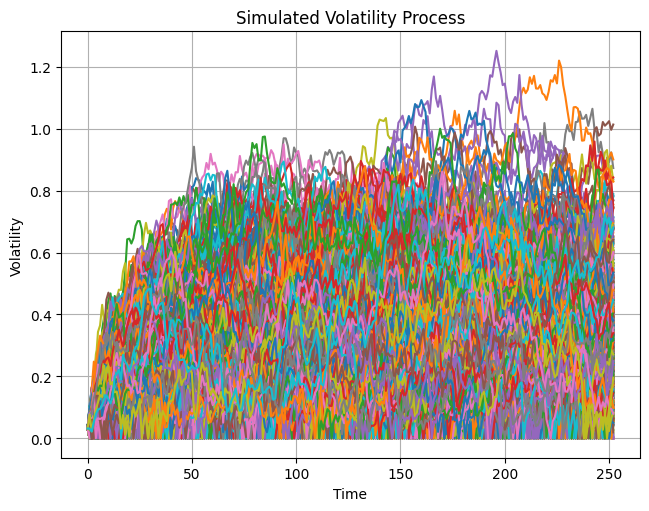

In [46]:
# Vol process
S_t, v_t = model.simulate(S0, T, r, q, npaths = 1000)
plt.plot(np.sqrt(v_t))
plt.tight_layout()
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.title('Simulated Volatility Process')
plt.grid()
plt.show()

### ***4. Call Prices Check***

Max relative error between Carr-Madan and Heston: 1.3905e-08


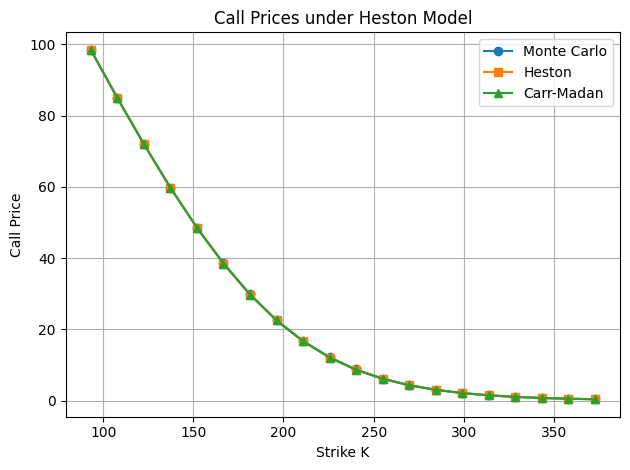

In [53]:
# Strikes
K = np.linspace(0.5*S0, 2*S0, 20)

mc_prices = model.monte_carlo_call(T, S0, r, q, K)
heston_prices =  model.heston_call(T, S0, r, q, K)
fft_prices = model.carr_madan_call(T, S0, r, q, K)
print(f"Max relative error between Carr-Madan and Heston: {np.max(np.abs(fft_prices/heston_prices - 1)):.4e}")

# Plot
plt.plot(K, mc_prices, 'o-', label='Monte Carlo')
plt.plot(K, heston_prices, 's-', label='Heston')
plt.plot(K, fft_prices, '^-', label='Carr-Madan')
plt.xlabel('Strike K')
plt.ylabel('Call Price')
plt.title('Call Prices under Heston Model')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

### ***5. Pricing***

In [ ]:
# Pricing 
K = 200; B = 150; n = 1000; seed = 2025; paths = 10**5; steps = 500
pricer = Pricer(model)

# Put Option 
mtm = 26_149.40 
put_price = pricer.european(T, S0, r, q, K, type='Put')*n 
print(f"European Put Price: {put_price:.2f}; Relative error: {(put_price/mtm - 1):.3%}")

# Digital Option
mtm = 409.91
digital_price = pricer.digital(T, S0, r, q, K, type='Call')*n
print(f"Digital Call Price: {digital_price:.2f}; Relative error: {(digital_price/mtm - 1):.3%}")

# UpAndIn Barrier Option
mtm = 21_502.32
barrier_type = 'UpAndIn' 
barrier_price = pricer.barrier(T, S0, r, q, K, B, type=barrier_type, npaths = paths, nsteps = steps, seed = seed)*n
print(f"Barrier {barrier_type} Price: {barrier_price:.2f}; Relative error: {(barrier_price/mtm - 1):.3%}")

# UpAndOut Barrier Option
mtm = 0.00
barrier_type = 'UpAndOut' 
barrier_price = pricer.barrier(T, S0, r, q, K, B, type=barrier_type, npaths = paths, nsteps = steps, seed = seed)*n
print(f"Barrier {barrier_type} Price: {barrier_price:.2f}; Relative error: {(barrier_price/mtm - 1):.3%}")

# DownAndOut Barrier Option
mtm = 20_164.98
barrier_type = 'DownAndOut' 
barrier_price = pricer.barrier(T, S0, r, q, K, B, type=barrier_type, npaths = paths, nsteps = steps, seed = seed)*n
print(f"Barrier {barrier_type} Price: {barrier_price:.2f}; Relative error: {(barrier_price/mtm - 1):.3%}")

# DownAndIn Barrier Option
mtm = 1_337.34
barrier_type = 'DownAndIn' 
barrier_price = pricer.barrier(T, S0, r, q, K, B, type=barrier_type, npaths = paths, nsteps = steps, seed = seed)*n
print(f"Barrier {barrier_type} Price: {barrier_price:.2f}; Relative error: {(barrier_price/mtm - 1):.3%}")